In [1]:
import numpy as np
import os
import dask.array as da
import glob
from dask import array as da
import os
import numpy as np
def read_im(path, return_pos=False):
    dirname = os.path.dirname(path)
    fov = os.path.basename(path).split('_')[-1].split('.')[0]
    file_ = os.path.join(dirname, fov, 'data')
    
    xml_file = os.path.splitext(path)[0] + '.xml'
    txt = open(xml_file, 'r').read()
    tag = '<stage_position type="custom">'
    x, y = eval(txt.split(tag)[-1].split('</')[0])
    if r'.fast.zarr' in txt:
        image = da.from_zarr(path)
        ncols = 5
        image = image.reshape([-1,ncols,image.shape[-2],image.shape[-1]])
        image = image.swapaxes(0,1)
        if image.dtype == np.uint8:
            image = image.astype(np.uint16) 
            image = image*image
            image = da.array([image[1]+image[2],image[3],image[4],image[0]])
    else:
        image = da.from_zarr(file_)[1:]
    
        shape = image.shape
        tag = '<z_offsets type="string">'
        zstack = txt.split(tag)[-1].split('</')[0]
    
        nchannels = int(zstack.split(':')[-1])
        nzs = (shape[0] // nchannels) * nchannels
        image = image[:nzs].reshape([shape[0] // nchannels, nchannels, shape[-2], shape[-1]])
        image = image.swapaxes(0, 1)
        if image.dtype == np.uint8:
            image = image.astype(np.uint16) 
            image = image*image
    
    if return_pos:
        return image, x, y
    return image

def _wiener_3d(self, image):
    """Monkey pathc to compute the 3D wiener deconvolution

    Parameters
    ----------
    image: torch.Tensor
        3D image tensor

    Returns
    -------
    torch.Tensor of the 3D deblurred image

    """
    import torch
    from sdeconv.core import SSettings
    from sdeconv.deconv.wiener import pad_3d,laplacian_3d,unpad_3d
    
    image_pad, psf_pad, padding = pad_3d(image, self.psf / torch.sum(self.psf), self.pad)

    fft_source = torch.fft.fftn(image_pad)
    
    container = SSettings.instance()
    if not hasattr(container,'dic_psf'): container.dic_psf = {}
    if container.dic_psf.get('den'+str(fft_source.shape),None) is None:        
        psf_roll = torch.roll(psf_pad, int(-psf_pad.shape[0] / 2), dims=0)
        psf_roll = torch.roll(psf_roll, int(-psf_pad.shape[1] / 2), dims=1)
        psf_roll = torch.roll(psf_roll, int(-psf_pad.shape[2] / 2), dims=2)

        fft_psf = torch.fft.fftn(psf_roll)
        fft_laplacian = torch.fft.fftn(laplacian_3d(image_pad.shape))
        den = fft_psf * torch.conj(fft_psf) + self.beta * fft_laplacian * torch.conj(fft_laplacian)
        
        
        
        container.dic_psf['den'+str(fft_source.shape)] = den
        container.dic_psf['fft_psf'+str(fft_source.shape)] = fft_psf
    else:
        den = container.dic_psf['den'+str(fft_source.shape)].to(SSettings.instance().device)
        fft_psf = container.dic_psf['fft_psf'+str(fft_source.shape)].to(SSettings.instance().device)
    
    out_image = torch.real(torch.fft.ifftn((fft_source * torch.conj(fft_psf)) / den))
    if image_pad.shape != image.shape:
        return unpad_3d(out_image, padding)
    return out_image
def apply_deconv(imsm,psf=None,plt_val=False,parameters = {'method':'wiener','beta':0.001,'niter':50},gpu=False,force=False,pad=None):
    r"""Applies deconvolution to image <imsm> using sdeconv: https://github.com/sylvainprigent/sdeconv/
    Currently assumes 60x objective with ~1.4 NA using SPSFGibsonLanni. Should be modified to find 
    
    Recomendations: the default wiener method with a low beta is the best for very fast local fitting. Albeit larger scale artifacts.
    For images: recommend the lucy method with ~30 iterations.
    
    This wraps around pytoch.
    
    To install:
    pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
    pip install sdeconv
    Optional: decided to modify the __init__ file of the SSettingsContainer in 
    C:\Users\BintuLabUser\anaconda3\envs\cellpose\Lib\site-packages\sdeconv\core\_settings.py
    
    import os
    gpu = True
    if os.path.exists("use_gpu.txt"):
        gpu = eval(open("use_gpu.txt").read())
    self.device = torch.device("cuda:0" if (torch.cuda.is_available() and gpu) else "cpu")
    to toggle the GPU on or off. By default it just uses the GPU if GPU detected by pytorch"""
    
    #import sdeconv,os
    #fl = os.path.dirname(sdeconv.__file__)+os.sep+'core'+os.sep+'use_gpu.txt'
    #fid = open(fl,'w')
    #fid.write('True')
    #fid.close()
    import torch
    from sdeconv.core import SSettings
    obj = SSettings.instance()
    obj.device = torch.device("cuda:0" if (torch.cuda.is_available() and gpu) else "cpu")
    if force:
        if hasattr(obj,'dic_psf'): del obj.dic_psf
    # map to tensor
    
    imsm_ = torch.from_numpy(np.array(imsm,dtype=np.float32))
    if psf is None:
        from sdeconv.psfs import SPSFGibsonLanni
        #psf_generator = SPSFGaussian((1,1.5, 1.5), imsm_.shape)
        psf_generator = SPSFGibsonLanni(M=60,shape=imsm_.shape)
        psf = psf_generator().to(obj.device)
    else:
        psff = np.zeros(imsm_.shape,dtype=np.float32)
                
        slices = [(slice((s_psff-s_psf_full_)//2,(s_psff+s_psf_full_)//2),slice(None)) if s_psff>s_psf_full_ else
         (slice(None),slice((s_psf_full_-s_psff)//2,(s_psf_full_+s_psff)//2))
          
          for s_psff,s_psf_full_ in zip(psff.shape,psf.shape)]
        sl_psff,sl_psf_full_ = list(zip(*slices))
        psff[sl_psff]=psf[sl_psf_full_]
        psf = torch.from_numpy(np.array(psff,dtype=np.float32)).to(obj.device)
        
    method = parameters.get('method','wiener')
    if pad is None:
        pad = int(np.min(list(np.array(imsm.shape)-1)+[50]))
    if method=='wiener':
        from sdeconv.deconv import SWiener
        beta = parameters.get('beta',0.001)
        filter_ = SWiener(psf, beta=beta, pad=pad)
        #monkey patch _wiener_3d to allow recycling the fft of the psf components
        filter_._wiener_3d = _wiener_3d.__get__(filter_, SWiener)
    elif method=='lucy':
        from sdeconv.deconv import SRichardsonLucy
        niter = parameters.get('niter',50)
        filter_ = SRichardsonLucy(psf, niter=niter, pad=pad)
    elif method=='spitfire':
        from sdeconv.deconv import Spitfire
        filter_ = Spitfire(psf, weight=0.6, reg=0.995, gradient_step=0.01, precision=1e-6, pad=pad)
    out_image = filter_(imsm_)
    out_image = out_image.cpu().detach().numpy().astype(np.float32)
    if plt_val:
        import napari
        viewer = napari.view_image(out_image)
        viewer.add_image(imsm)
    return out_image
def full_deconv(im_,s_=300,pad=100,psf=None,parameters={'method': 'wiener', 'beta': 0.001, 'niter': 50},gpu=True,force=True):
    im0=np.zeros_like(im_)
    sx,sy = im_.shape[1:]
    ixys = []
    for ix in np.arange(0,sx,s_):
        for iy in np.arange(0,sy,s_):
            ixys.append([ix,iy])
    
    for ix,iy in tqdm(ixys):#ixys:#tqdm(ixys):
        imsm = im_[:,ix:ix+pad+s_,iy:iy+pad+s_]
        if type(psf) is dict:
            keys = list(psf.keys())
            ikey = np.argmin(np.sum(np.abs(np.array(keys)-[0,ix,iy]),axis=-1))
            psf_ = psf[keys[ikey]]
            force=True
        else:
            psf_ = psf
        imt = apply_deconv(imsm,psf=psf_,parameters=parameters,gpu=gpu,plt_val=False,force=force)
        start_x = ix+pad//2 if ix>0 else 0
        end_x = ix+pad//2+s_
        start_y = iy+pad//2 if iy>0 else 0
        end_y = iy+pad//2+s_
        #print(start_x,end_x,start_y,end_y)
        im0[:,start_x:end_x,start_y:end_y] = imt[:,(start_x-ix):(end_x-ix),(start_y-iy):(end_y-iy)]
    return im0
from tqdm import tqdm
import cv2

In [2]:
all_fls = np.sort(glob.glob(r'Z:\MERFISHp\12_16_2025_BigSlideTest\H1_MER_set4\*.zarr'))

In [3]:
from cellpose import models, io
# Load model
model = models.CellposeModel(gpu=True)

In [ ]:
for fl in tqdm(all_fls[::-1]):
    fov = os.path.basename(fl).replace('.zarr','')
    htag = os.path.basename(os.path.dirname(fl))
    fl_segm = rf'Z:\MERFISHp\12_16_2025_BigSlideTest\Segmentation\{fov}--{htag}--segm.npz'
    if not os.path.exists(fl_segm):
        immed = np.load(r'Z:\MERFISHp\12_16_2025_BigSlideTest\V2_med3.npy')
        immed=immed/np.median(immed)
        immed = cv2.blur(immed,(20,20))
        im_dapi = np.array(read_im(fl)[-1],dtype=np.float32)/immed
        imdo = full_deconv(im_dapi,s_=400,pad=100,psf=np.load(r'Z:\MERFISHp\12_16_2025_BigSlideTest\psf_single.npy'),
                    parameters={'method': 'wiener', 'beta': 0.005, 'niter': 50},gpu=True,force=False)
        
        img = np.clip(imdo[:,::3,::3]/50000,0,1)
        res = model.eval(img,
                                batch_size=8,
                                resample=False,
                                channel_axis=None,
                                z_axis=0,
                                normalize=False,
                                invert=False,
                                rescale=None,
                                diameter=None,
                                flow_threshold=-10,
                                cellprob_threshold=-10,
                                do_3D=True,
                                anisotropy=None,
                                flow3D_smooth=5,
                                stitch_threshold=0.5,
                                min_size=400,
                                max_size_fraction=0.4,
                                niter=None,
                                augment=False,
                                tile_overlap=0.1,
                                bsize=256,
                                compute_masks=True,
                                progress=True,
                            )
        
        
        mask = res[0].copy()
        ucells,volms  = np.unique(mask,return_counts=True)
        mask[np.isin(mask,ucells[volms<5000])]=0
        np.savez_compressed(fl_segm,segm = mask,shape=im_dapi.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.51it/s]


In [72]:
import napari
V = napari.Viewer()
V.add_image(img)
V.add_labels(mask)

<Labels layer 'mask' at 0x2169752e050>

(array([118.,  60.,   7.,  11.,  10.,  20.,  31.,  55.,  99.,  52.]),
 array([ 5.99146455,  6.56860243,  7.14574031,  7.72287819,  8.30001607,
         8.87715396,  9.45429184, 10.03142972, 10.6085676 , 11.18570548,
        11.76284336]),
 <BarContainer object of 10 artists>)

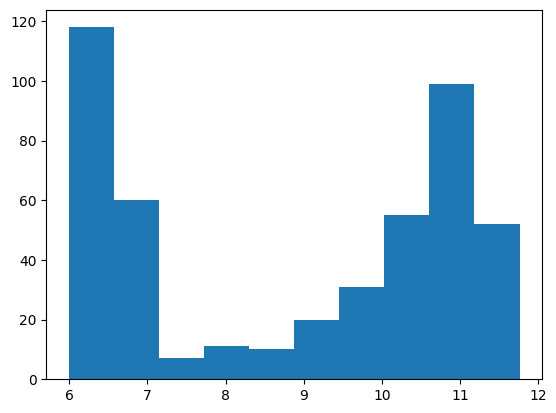

In [67]:
import matplotlib.pylab as plt
plt.hist(np.log(volms[1:]))

In [60]:
print(fl_segm)

Z:\MERFISHp\12_16_2025_BigSlideTest\Segmentation\Conv_zscan4__210--H1_MER_set4--segm.npz


In [69]:
np.exp(8.5)

np.float64(4914.768840299134)

In [70]:
np.median(volms[volms>2000])

np.float64(46399.5)

<Labels layer 'Labels' at 0x2169b5cb700>

In [41]:
import napari
V = napari.Viewer()
V.add_image(imdo[:,::3,::3])

<Image layer 'Image' at 0x21630950c70>

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 10.25it/s]


C:\Users\miket\AppData\Local\Temp\ipykernel_23192\4228981805.py:1: FutureWarning: `napari.view_image` is deprecated and will be removed in napari 0.7.0.
Use `viewer = napari.Viewer(); viewer.add_image(...)` instead.
  napari.view_image(imd[:,::3,::3])


Viewer(camera=Camera(center=(0.0, np.float64(466.5), np.float64(466.5)), zoom=np.float64(0.6102783725910064), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(np.float64(19.0), 1.0, 0.0), viewbox=None, scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=np.float64(0.0), stop=np.float64(39.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(933.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(933.0), step=np.float64(1.0))), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(np.float64(19.0), np.float64(466.0), np.float64(466.0)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enable